#Imports and Variables

**Google-colabs:** https://colab.research.google.com/drive/19TUJHL5S6dVNajnW7zqVVChRxLz7vfhv?usp=sharing

In [1]:
import os
import glob
import shutil
import random
import time

import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn, optim
from PIL import Image
from torchvision.transforms import Resize
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


#Functions

In [2]:
class FetalPlaneDataset(Dataset):
    """Fetal Plane dataset."""

    def __init__(self,
                 root_dir,
                 csv_file,
                 plane=None,
                 brain_plane=None,
                 us_machine=None,
                 operator_number=None,
                 transform=None,
                 split_type=None,
                 split="train",
                 train_size=100,
                 downsampling_factor=2,
                 return_labels=False
                 ):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
            plane: 'Fetal brain'; 'Fetal thorax'; 'Maternal cervix'; 'Fetal femur'; 'Fetal thorax'; 'Other'
            brain_plane: 'Trans-ventricular'; 'Trans-thalamic'; 'Trans-cerebellum'
            us_machine: 'Voluson E6';'Voluson S10'
            operator_number: 'Op. 1'; 'Op. 2'; 'Op. 3';'Other'
            split_type (string, optional): Method to split dataset, supports "manual", and "csv"
            split (string): Which partition to return, supports "train", and "valid"
            train_size:  Limit dataset size to 100 images (for training)
            return_labels: Return the plane of the image

        return image, downsampled_image
        """
        self.transform = transform
        self.downsampling_factor = downsampling_factor
        self.root_dir = root_dir
        self.csv_file = pd.read_csv(csv_file, sep=';')
        self.return_labels = return_labels
        self.plane = plane

        if self.plane:
          self.csv_file = self.csv_file[self.csv_file['Plane'] == self.plane]
          if self.plane == 'Fetal brain':
            self.csv_file = self.csv_file[self.csv_file['Brain_plane'] != 'Other']
        if brain_plane:
            self.csv_file = self.csv_file[self.csv_file['Brain_plane'] == brain_plane]
        if us_machine is not None:
            self.csv_file = self.csv_file[self.csv_file['US_Machine'] == us_machine]
        if operator_number is not None:
            self.csv_file = self.csv_file[self.csv_file['Operator'] == operator_number]

        self.train_size = train_size

        # Split data manually
        if split_type == "manual":
            if split == "train":
                self.csv_file = self.csv_file[:self.train_size]
            elif split == "valid":
                self.csv_file = self.csv_file[self.train_size:]
        # Split data according to CSV
        elif split_type == "csv":
            if split == "train":
                self.csv_file = self.csv_file[self.csv_file['Train '] == 1]
            elif split == "valid":
                self.csv_file = self.csv_file[self.csv_file['Train '] == 0]

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        # Load the image from file

        # print(f'idx: {idx} \n')
        # print(f'self.csv_file.iloc[idx, 0]: {self.csv_file.iloc[idx, 0]} \n')

        img_name = os.path.join(self.root_dir,
                                self.csv_file.iloc[idx, 0] + '.png')
        # print(img_name)
        image = Image.open(img_name)  # <class 'numpy.ndarray'>

        # print(type(image))
        # print(image.dtype)

        # Preprocess and augment the image
        if self.transform:
            image = self.transform(image)

        ## Downsample image for SRGAN
        size = image.size()
        tr_resize = Resize((int(size[1] / self.downsampling_factor), int(size[2] / self.downsampling_factor)))
        ds_image = tr_resize(image)
        # .cpu().numpy()#TypeError: Cannot interpret 'torch.float32' as a data type

        # Return labels for classification task
        if self.return_labels:
            if self.plane == 'Fetal brain':
              im_plane = np.expand_dims(np.asarray(self.csv_file.iloc[idx, 3]), axis=0)
              if im_plane == 'Trans-thalamic':
                im_plane = 0
              elif im_plane == 'Trans-ventricular':
                im_plane = 1
              elif im_plane == 'Trans-cerebellum':
                im_plane = 2
            else:
              im_plane = np.expand_dims(np.asarray(self.csv_file.iloc[idx, 2]), axis=0)
              if im_plane == 'Other':
                  im_plane = 0
              elif im_plane == 'Fetal brain':
                  im_plane = 1
              elif im_plane == 'Fetal abdomen':
                  im_plane = 2
              elif im_plane == 'Fetal femur':
                  im_plane = 3
              elif im_plane == 'Fetal thorax':
                  im_plane = 4
              elif im_plane == 'Maternal cervix':
                  im_plane = 4
            return image, im_plane
        else:
            return image, ds_image


class AfricanFetalPlaneDataset(Dataset):
    """African Fetal Plane dataset."""

    def __init__(self,
                 root_dir,
                 csv_file,
                 plane=None,
                 country=None,
                 transform=None,
                 split_type=None,
                 split="Train",
                 train_size=100,
                 downsampling_factor=2,
                 return_labels=False
                 ):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            plane: 'Fetal brain', 'Fetal abdomen','Fetal femur', 'Fetal thorax'
            country: 'Algeria', 'Egypt', 'Malawi', 'Uganda', 'Ghana'
            transform (callable, optional): Optional transform to be applied on a sample.
            split_type (string, optional): Method to split dataset, supports "manual", and "csv"
            split (string): Which partition to return, supports "train", and "valid"
            train_size:  Limit dataset size to 100 images (for training)
            downsampling_factor: downsampling image
            return_labels: Return the plane and country of the image

        return image, downsampled_image
        """
        self.transform = transform
        self.downsampling_factor = downsampling_factor
        self.root_dir = root_dir
        self.plane = plane
        self.country = country
        self.csv_file = pd.read_csv(csv_file, sep=',')
        self.return_labels = return_labels

        if self.plane is not None:
            self.csv_file = self.csv_file[self.csv_file['Plane'] == self.plane]
        if self.country is not None:
            self.csv_file = self.csv_file[self.csv_file['Center'] == self.country]

        # Split data manually
        if split_type == "manual":
            if split == "train":
                self.csv_file = self.csv_file[:train_size]
            elif split == "valid":
                self.csv_file = self.csv_file[train_size:]
        # Split data according to CSV
        elif split_type == "csv":
            if split == "train":
                self.csv_file = self.csv_file[self.csv_file['Train'] == 1]
            elif split == "valid":
                self.csv_file = self.csv_file[self.csv_file['Train'] == 0]

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        # Load the random image from file

        # print(f'idx: {idx} \n')
        # print(f'self.csv_file.iloc[idx, 4]: {self.csv_file.iloc[idx, 4]} \n')#Filename

        img_name = os.path.join(self.root_dir,
                                self.csv_file.iloc[idx, 4] + '.png') #Filename
        image = Image.open(img_name)  # <class 'numpy.ndarray'>

        # print(type(image))
        # print(image.dtype)

        if self.transform:
            image = self.transform(image)

        ## Downsample image for SRGAN
        size = image.size()
        tr_resize = Resize((int(size[1] / self.downsampling_factor), int(size[2] / self.downsampling_factor)))
        ds_image = tr_resize(image)

        # Return labels for classification task
        if self.return_labels:
            plane = np.expand_dims(np.asarray(self.csv_file.iloc[idx, 1]), axis=0)
            if plane == 'Fetal brain':
                plane = 0
            elif plane == 'Fetal abdomen':
                plane = 1
            elif plane == 'Fetal femur':
                plane = 2
            elif plane =='Fetal thorax':
                plane = 3
            return image, plane

        else:
            return image, ds_image

In [3]:
def save_model(model, optimizer, epoch, best_epoch, train_losses, val_losses, save_path):
  state = {
    'epoch': epoch,
    'best_epoch': best_epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses
  }
  torch.save(state, save_path)

def load_model(model_path, device, model=None, optimizer=None):
  if device == "cpu":
    state = torch.load(model_path, map_location=torch.device('cpu'))
  else:
    state = torch.load(model_path)

  epoch = state['epoch']
  best_epoch = state['best_epoch']
  train_losses = state['train_losses']
  val_losses = state['val_losses']

  if model:
    model.load_state_dict(state['state_dict'])
  if optimizer:
    optimizer.load_state_dict(state['optimizer'])

  return epoch, best_epoch, model, optimizer, train_losses, val_losses


def train_model(train_dataloader, val_dataloader, model, optimizer, num_epochs, model_save_path, checkpoint_save_path, device, load_checkpoint=False):
  start = time.time()
  train_losses = []
  val_losses = []
  best_loss = 100
  best_epoch = 0
  s_epoch = 0

  if load_checkpoint:
    s_epoch, best_epoch, model, optimizer, train_losses, val_losses = load_model(checkpoint_save_path, device, model, optimizer)
    best_loss = val_losses[best_epoch]

  print(model)
  for epoch in range(s_epoch, num_epochs):
    model.train()
    running_loss = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels).mean()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if i % 10 == 0:
        print(f"Epoch {epoch} iteration {i} training loss: {loss.item()}")

    train_epoch_loss = running_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)


    model.eval()
    with torch.no_grad():
      running_loss = 0
      for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels).mean()
        running_loss += loss.item()
      val_epoch_loss = running_loss / len(val_dataloader)
      val_losses.append(val_epoch_loss)
      if epoch == 0:
        best_loss = val_epoch_loss
      elif val_epoch_loss < best_loss:
        best_loss = val_epoch_loss
        best_epoch = epoch
        save_model(model, optimizer, epoch, best_epoch, train_losses, val_losses, model_save_path)

      save_model(model, optimizer, epoch, best_epoch, train_losses, val_losses, checkpoint_save_path)
      print(f"Epoch {epoch} average training loss: {train_epoch_loss}, average validation loss: {val_epoch_loss}")
      end = time.time()
      print(f"Running time: {end - start}s")
  end = time.time()
  print(f"Execution time: {end - start}s")

In [4]:
def plot_training_curve(train_losses, val_losses, best_epoch=None, title=None):
  plt.plot(train_losses, label="Train")
  plt.plot(val_losses, label="Test")
  if title:
    plt.title(title)
  if best_epoch:
    plt.axvline(x=best_epoch, color='#9f9f9f', label=(f"Best Epoch: {best_epoch}"), ls="--", lw=1)
  plt.legend()
  plt.show()

def evaluate_model(y_true, y_pred, class_names):
  accuracy = accuracy_score(y_true, y_pred)
  p, r, f, s = precision_recall_fscore_support(y_true, y_pred)

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {p}")
  print(f"Recall: {r}")
  print(f"F1: {f}")
  print(f"Support: {s}")

  ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names)
  plt.show()



#African Dataset

## Train Model

In [ ]:
image_size = 224
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

african_train_dataset = AfricanFetalPlaneDataset("/content/drive/MyDrive/african_dataset/Images",
                                           "/content/drive/MyDrive/african_dataset/African_planes_database.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="train")
african_val_dataset = AfricanFetalPlaneDataset("/content/drive/MyDrive/african_dataset/Images",
                                           "/content/drive/MyDrive/african_dataset/African_planes_database.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")
print((len(african_train_dataset), len(african_val_dataset)))

(217, 233)


In [ ]:
train_dataloader = DataLoader(african_train_dataset, batch_size=24, shuffle="True")
val_dataloader = DataLoader(african_val_dataset, batch_size=24)
ims, planes = next(iter(val_dataloader))

# for i, p in list(zip(ims, planes)):
#     plt.imshow(i[0], cmap="gray")
#     plt.title(f"Plane: {p}")
#     plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(afr_model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 100
model_save_path = '/content/drive/MyDrive/xfetus/models/afr_clf.pt'
checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_ckpt.pt'

train_model(train_dataloader,
            val_dataloader,
            afr_model,
            optimizer,
            num_epochs,
            model_save_path,
            checkpoint_save_path)

Epoch 0 iteration 0 training loss: 9.006608009338379
Epoch 0 average training loss: 3.02605887055397, average validation loss: 2.584437000751495
Epoch 1 iteration 0 training loss: 0.8622862696647644
Epoch 1 average training loss: 0.4109239913523197, average validation loss: 6.270850348024396
Epoch 2 iteration 0 training loss: 0.17873434722423553
Epoch 2 average training loss: 0.23085407204926015, average validation loss: 2.167358028888702
Epoch 3 iteration 0 training loss: 0.08326007425785065
Epoch 3 average training loss: 0.11663010437041521, average validation loss: 0.8639011472463608
Epoch 4 iteration 0 training loss: 0.018215307965874672
Epoch 4 average training loss: 0.5299437992274761, average validation loss: 0.6051412708126008
Epoch 5 iteration 0 training loss: 0.5211815237998962
Epoch 5 average training loss: 0.38146598818711935, average validation loss: 0.49471499025821686
Epoch 6 iteration 0 training loss: 0.06591221690177917
Epoch 6 average training loss: 0.1127691473811864

## Train with augmentation

In [9]:
image_size = 224
transform_operations=transforms.Compose([
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(15),
                        transforms.RandomResizedCrop([image_size, image_size], (0.8, 1.0)),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Normalize((0.5), (0.5)),
                        ])
val_transforms = transform_operations=transforms.Compose([
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

african_train_dataset = AfricanFetalPlaneDataset("/content/drive/MyDrive/african_dataset/Images",
                                           "/content/drive/MyDrive/african_dataset/African_planes_database.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="train")
african_val_dataset = AfricanFetalPlaneDataset("/content/drive/MyDrive/african_dataset/Images",
                                           "/content/drive/MyDrive/african_dataset/African_planes_database.csv",
                                           transform=val_transforms,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")
print((len(african_train_dataset), len(african_val_dataset)))

(217, 233)


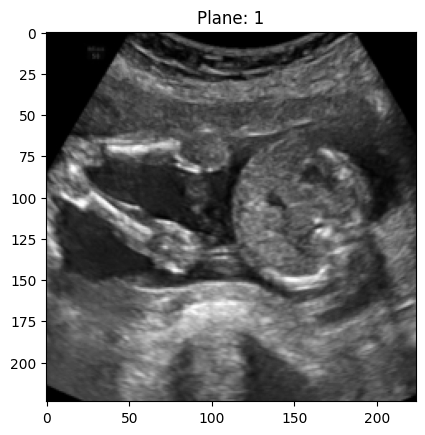

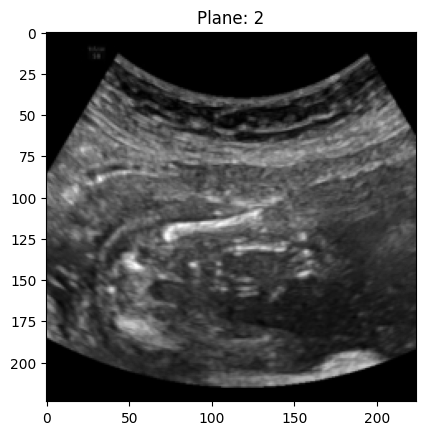

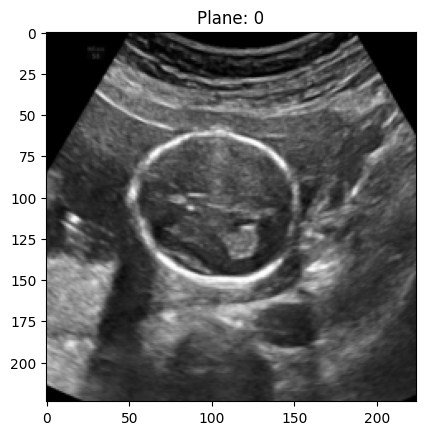

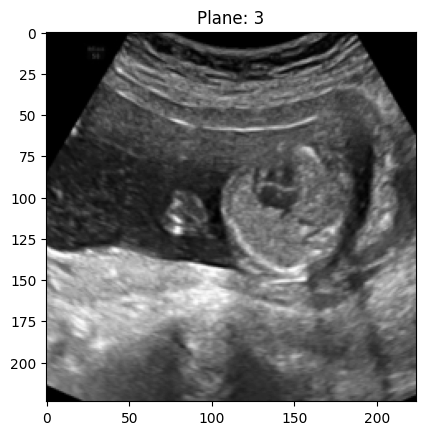

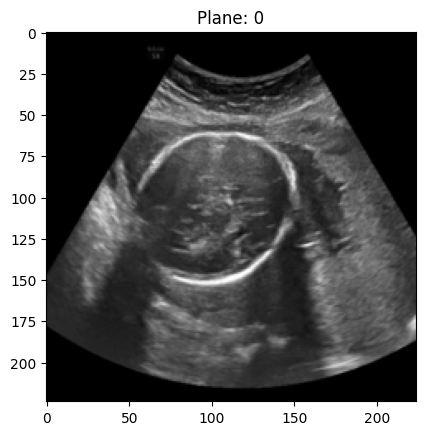

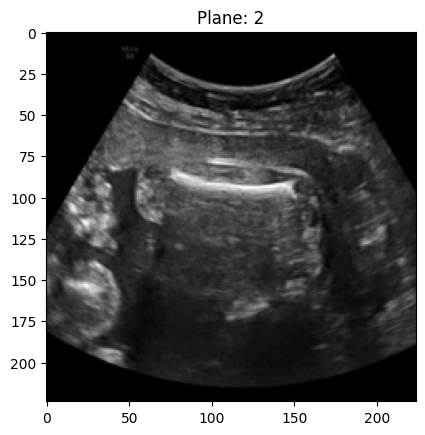

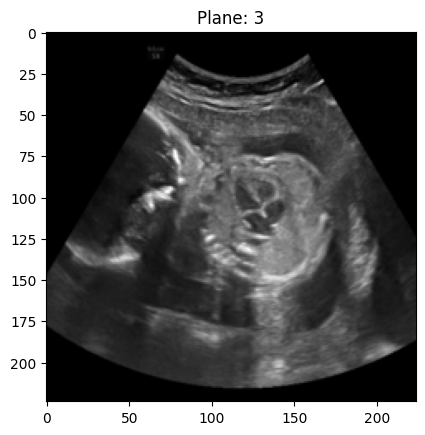

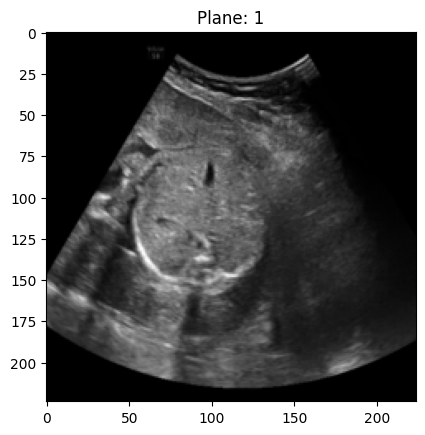

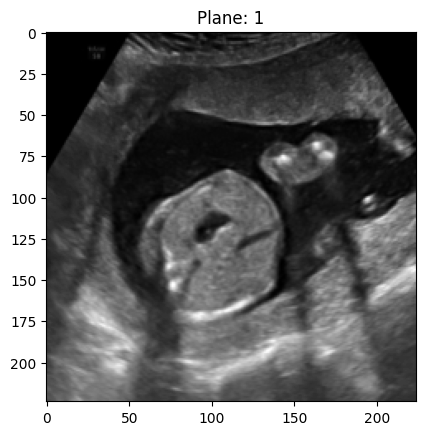

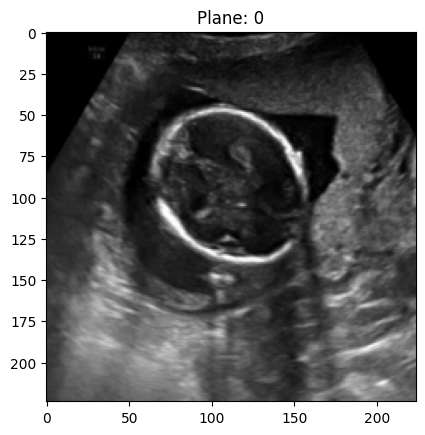

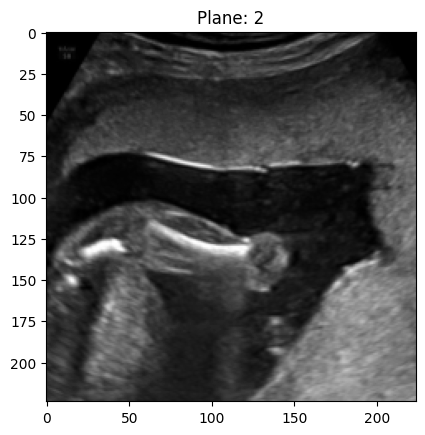

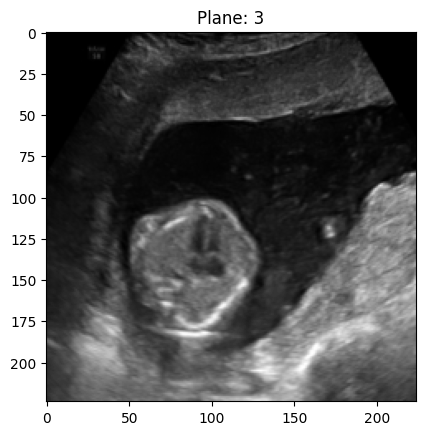

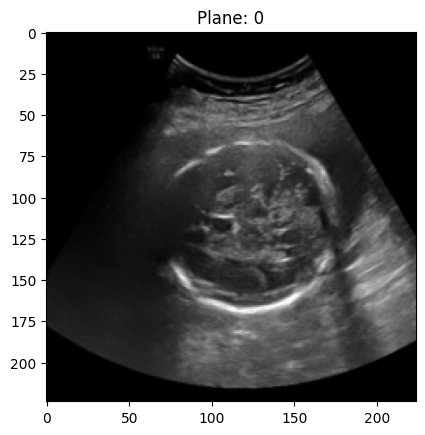

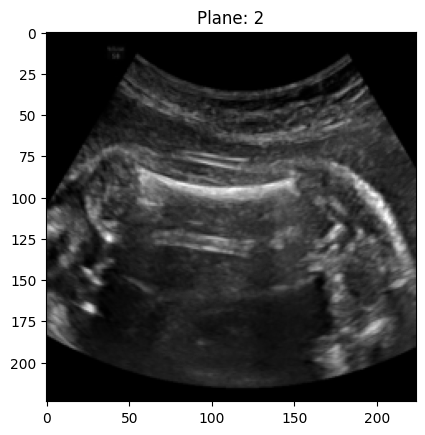

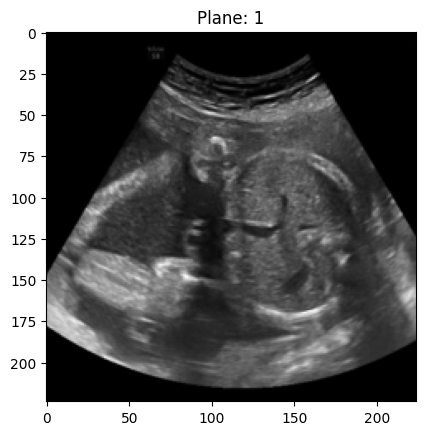

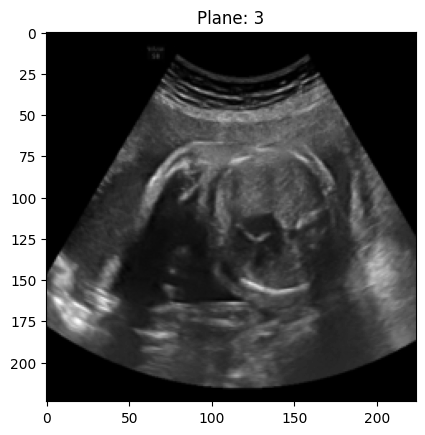

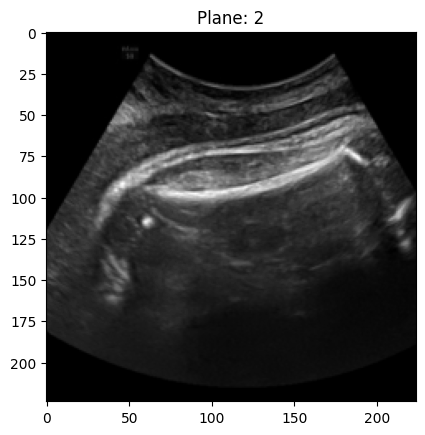

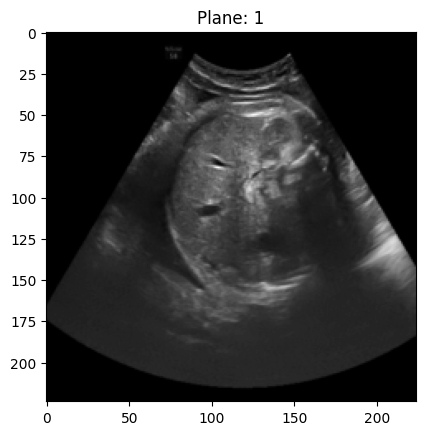

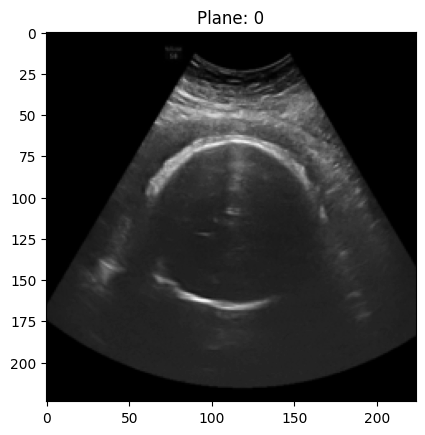

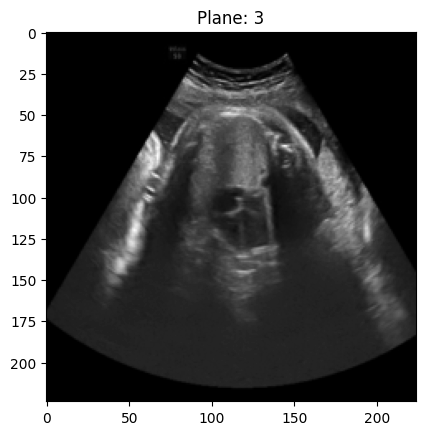

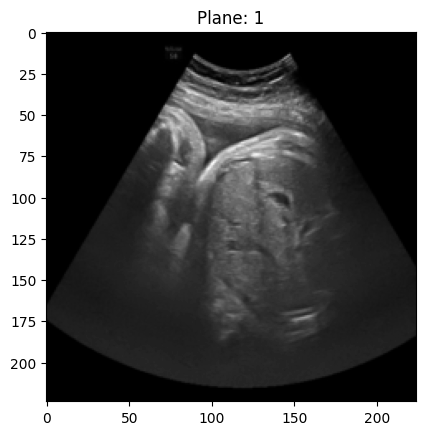

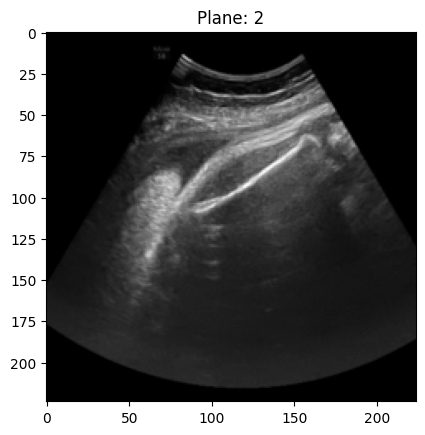

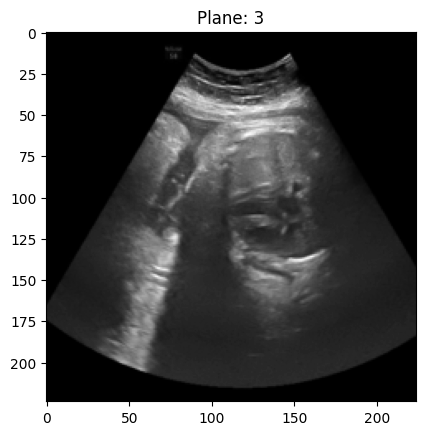

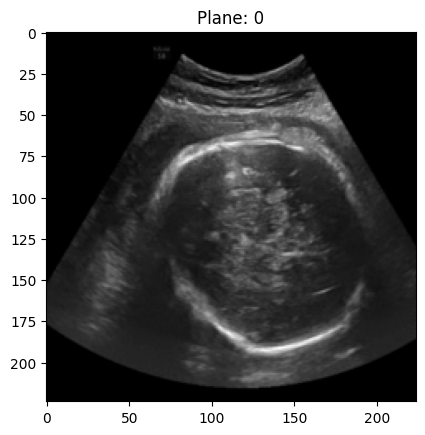

In [13]:
train_dataloader = DataLoader(african_train_dataset, batch_size=24, shuffle="True")
val_dataloader = DataLoader(african_val_dataset, batch_size=24)
ims, planes = next(iter(val_dataloader))

for i, p in list(zip(ims, planes)):
    plt.imshow(i[0], cmap="gray")
    plt.title(f"Plane: {p}")
    plt.show()

In [14]:
afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(afr_model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
num_epochs = 100
model_save_path = '/content/drive/MyDrive/xfetus/models/afr_aug_clf.pt'
checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_aug_ckpt.pt'

train_model(train_dataloader,
            val_dataloader,
            afr_model,
            optimizer,
            num_epochs,
            model_save_path,
            checkpoint_save_path,
            device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Train with 80/20

In [ ]:
image_size = 224
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

african_train_dataset = AfricanFetalPlaneDataset("/content/drive/MyDrive/african_dataset/Images",
                                           "/content/drive/MyDrive/african_dataset/African_planes_database_8020.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="train")
african_val_dataset = AfricanFetalPlaneDataset("/content/drive/MyDrive/african_dataset/Images",
                                           "/content/drive/MyDrive/african_dataset/African_planes_database_8020.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")
print((len(african_train_dataset), len(african_val_dataset)))

(362, 88)


In [ ]:
train_dataloader = DataLoader(african_train_dataset, batch_size=24, shuffle="True")
val_dataloader = DataLoader(african_val_dataset, batch_size=24)
ims, planes = next(iter(val_dataloader))

# for i, p in list(zip(ims, planes)):
#     plt.imshow(i[0], cmap="gray")
#     plt.title(f"Plane: {p}")
#     plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(afr_model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 100
model_save_path = '/content/drive/MyDrive/xfetus/models/afr_clf_8020.pt'
checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_ckpt_8020.pt'

train_model(train_dataloader,
            val_dataloader,
            afr_model,
            optimizer,
            num_epochs,
            model_save_path,
            checkpoint_save_path)

Epoch 0 iteration 0 training loss: 8.574137687683105
Epoch 0 iteration 10 training loss: 0.9530628323554993
Epoch 0 average training loss: 1.977594220545143, average validation loss: 7.427393198013306
Epoch 1 iteration 0 training loss: 0.49223652482032776
Epoch 1 iteration 10 training loss: 0.23260235786437988
Epoch 1 average training loss: 0.3846316672861576, average validation loss: 0.42614972963929176
Epoch 2 iteration 0 training loss: 0.4330871105194092
Epoch 2 iteration 10 training loss: 0.13155347108840942
Epoch 2 average training loss: 0.29534943867474794, average validation loss: 0.4304193779826164
Epoch 3 iteration 0 training loss: 0.036957036703825
Epoch 3 iteration 10 training loss: 0.052318111062049866
Epoch 3 average training loss: 0.15690240543335676, average validation loss: 0.9590022750198841
Epoch 4 iteration 0 training loss: 0.09637650847434998
Epoch 4 iteration 10 training loss: 0.008301964029669762
Epoch 4 average training loss: 0.13135888380929828, average validati

##Evaluate

In [ ]:
model_save_path = '/content/drive/MyDrive/xfetus/models/afr_clf.pt'

afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)

best_epoch, model, optimizer, train_losses, val_losses = load_model(model_save_path, device, afr_model)
print(f"Loaded model from best epoch {best_epoch} with validation loss: {val_losses[-1]}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded model from best epoch 26 with validation loss: 0.16319658383727073


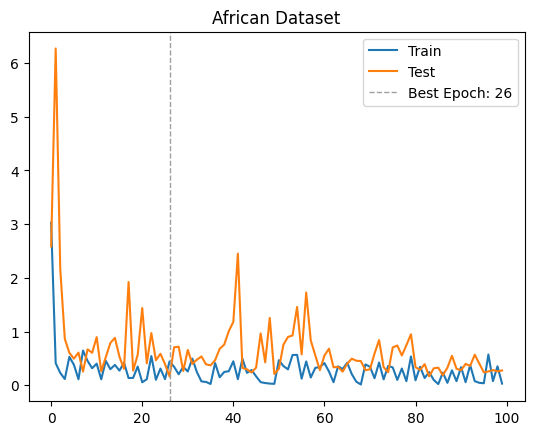

In [ ]:
checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_ckpt.pt'
_, _, _, full_train_losses, full_val_losses = load_model(checkpoint_save_path, device)
title = "African Dataset"
plot_training_curve(full_train_losses, full_val_losses, best_epoch, title)

In [ ]:
image_size = 224
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

african_val_dataset = AfricanFetalPlaneDataset("/content/drive/MyDrive/african_dataset/Images",
                                           "/content/drive/MyDrive/african_dataset/African_planes_database.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")

val_dataloader = DataLoader(african_val_dataset, batch_size=8)

afr_model.eval()
pred_list = []
label_list = []
with torch.no_grad():
  for inputs, labels in val_dataloader:
    # plt.imshow(inputs)
    inputs = inputs.to(device)
    outputs = afr_model(inputs)
    _, preds = torch.max(outputs, 1)
    pred_list = np.concatenate((pred_list, preds.detach().cpu().numpy()))
    label_list = np.concatenate((label_list, labels))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy: 0.9399141630901288
Precision: [1.         0.90909091 0.92537313 0.92105263]
Recall: [0.95384615 0.92307692 0.96875    0.8974359 ]
F1: [0.97637795 0.91603053 0.94656489 0.90909091]
Support: [65 65 64 39]


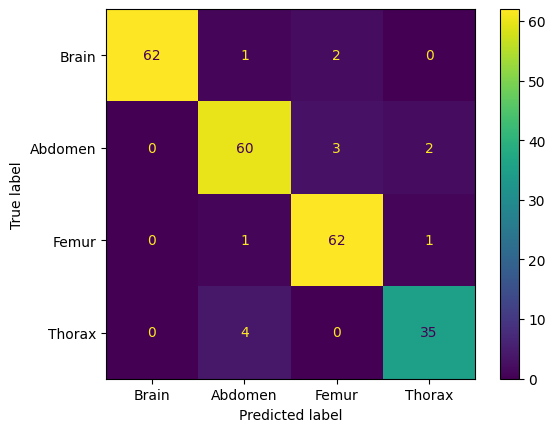

In [ ]:
class_names = ["Brain", "Abdomen", "Femur", "Thorax"]
evaluate_model(label_list, pred_list, class_names)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy: 0.9204545454545454
Precision: [1.         0.875      0.92       0.88235294]
Recall: [0.91666667 0.875      1.         0.88235294]
F1: [0.95652174 0.875      0.95833333 0.88235294]
Support: [24 24 23 17]


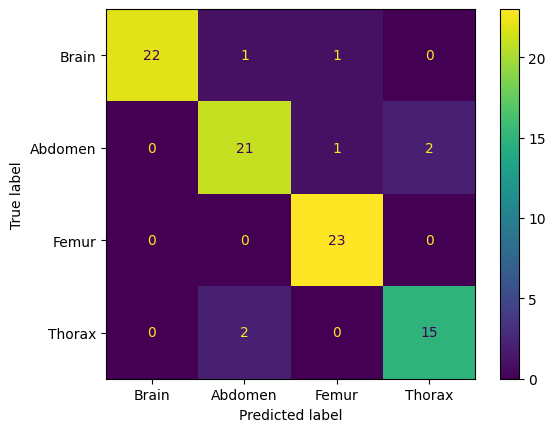

In [ ]:
# Evaluate with validation from 80/20 split
image_size = 224
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

african_val_dataset = AfricanFetalPlaneDataset("/content/drive/MyDrive/african_dataset/Images",
                                           "/content/drive/MyDrive/african_dataset/African_planes_database_8020.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")

val_dataloader = DataLoader(african_val_dataset, batch_size=8)

afr_model.eval()
pred_list = []
label_list = []
with torch.no_grad():
  for inputs, labels in val_dataloader:
    # plt.imshow(inputs)
    inputs = inputs.to(device)
    outputs = afr_model(inputs)
    _, preds = torch.max(outputs, 1)
    pred_list = np.concatenate((pred_list, preds.detach().cpu().numpy()))
    label_list = np.concatenate((label_list, labels))

class_names = ["Brain", "Abdomen", "Femur", "Thorax"]
evaluate_model(label_list, pred_list, class_names)

## Evaluate with augmentation

In [16]:
model_save_path = '/content/drive/MyDrive/xfetus/models/afr_aug_clf.pt'

afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)

epoch, best_epoch, model, optimizer, train_losses, val_losses = load_model(model_save_path, device, afr_model)
print(f"Loaded model from best epoch {best_epoch} with validation loss: {val_losses[-1]}")

Loaded model from best epoch 78 with validation loss: 0.1185226053930819


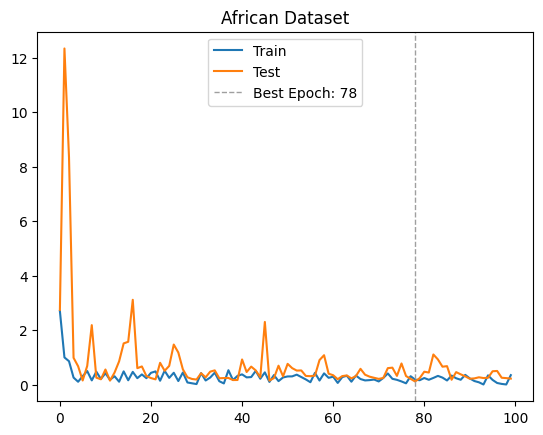

In [18]:
checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_aug_ckpt.pt'
_, _, _, _, full_train_losses, full_val_losses = load_model(checkpoint_save_path, device)
title = "African Dataset"
plot_training_curve(full_train_losses, full_val_losses, best_epoch, title)

In [21]:
image_size = 224
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])


african_val_dataset = AfricanFetalPlaneDataset("/content/drive/MyDrive/african_dataset/Images",
                                           "/content/drive/MyDrive/african_dataset/African_planes_database_8020.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")

afr_model.eval()
pred_list = []
label_list = []
with torch.no_grad():
  for inputs, labels in val_dataloader:
    # plt.imshow(inputs)
    inputs = inputs.to(device)
    outputs = afr_model(inputs)
    _, preds = torch.max(outputs, 1)
    pred_list = np.concatenate((pred_list, preds.detach().cpu().numpy()))
    label_list = np.concatenate((label_list, labels))


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy: 0.9656652360515021
Precision: [0.98461538 0.92537313 0.96923077 1.        ]
Recall: [0.98461538 0.95384615 0.984375   0.92307692]
F1: [0.98461538 0.93939394 0.97674419 0.96      ]
Support: [65 65 64 39]


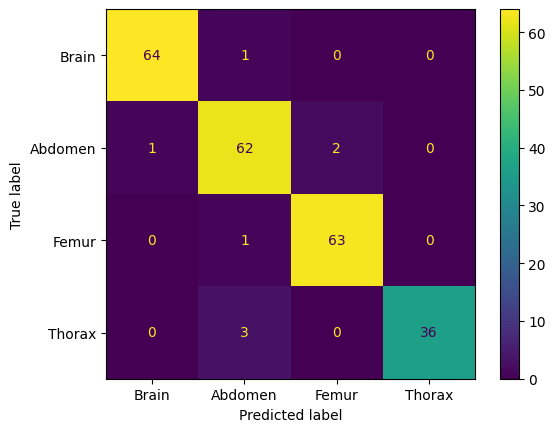

In [22]:
class_names = ["Brain", "Abdomen", "Femur", "Thorax"]
evaluate_model(label_list, pred_list, class_names)

## Evaluate 80/20

In [ ]:
model_save_path = '/content/drive/MyDrive/xfetus/models/afr_clf_8020.pt'

afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)

best_epoch, model, optimizer, train_losses, val_losses = load_model(model_save_path, device, afr_model)
print(f"Loaded model from best epoch {best_epoch} with validation loss: {val_losses[-1]}")

Loaded model from best epoch 53 with validation loss: 0.03932384049403481


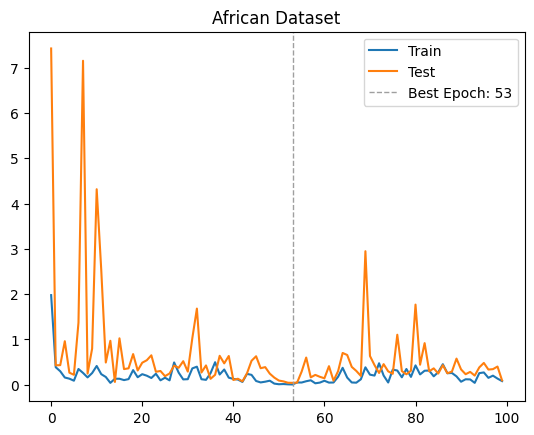

In [ ]:
checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_ckpt_8020.pt'
_, _, _, full_train_losses, full_val_losses = load_model(checkpoint_save_path, device)
title = "African Dataset"
plot_training_curve(full_train_losses, full_val_losses, best_epoch, title)

In [ ]:
image_size = 224
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

african_val_dataset = AfricanFetalPlaneDataset("/content/drive/MyDrive/african_dataset/Images",
                                           "/content/drive/MyDrive/african_dataset/African_planes_database_8020.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")

val_dataloader = DataLoader(african_val_dataset, batch_size=8)

afr_model.eval()
pred_list = []
label_list = []
with torch.no_grad():
  for inputs, labels in val_dataloader:
    # plt.imshow(inputs)
    inputs = inputs.to(device)
    outputs = afr_model(inputs)
    _, preds = torch.max(outputs, 1)
    pred_list = np.concatenate((pred_list, preds.detach().cpu().numpy()))
    label_list = np.concatenate((label_list, labels))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy: 0.9886363636363636
Precision: [1.         1.         0.95833333 1.        ]
Recall: [1.         0.95833333 1.         1.        ]
F1: [1.        0.9787234 0.9787234 1.       ]
Support: [24 24 23 17]


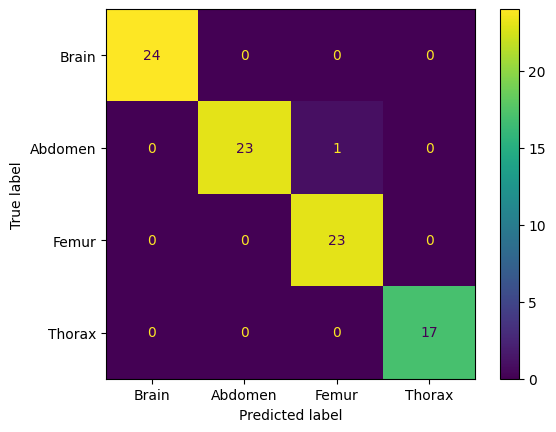

In [ ]:
class_names = ["Brain", "Abdomen", "Femur", "Thorax"]
evaluate_model(label_list, pred_list, class_names)

# Fetal Plane Dataset

## Train Brain Planes

In [ ]:
# !unzip /content/drive/MyDrive/FETAL_PLANES_ZENODO.zip -d /content/drive/MyDrive/fetalplane_dataset

In [ ]:
# image_size = 500
# transform_operations=transforms.Compose([
#                         #mt.RandRotate(range_x=0.1, prob=0.5),
#                         #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
#                         #mt.Resize([image_size, image_size]),
#                         transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
#                         transforms.ToTensor(),
#                         transforms.Resize([image_size, image_size], antialias=True),
#                         transforms.Normalize((0.5), (0.5)),
#                         ])

# fetalplane_train_dataset = FetalPlaneDataset("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/Images",
#                                            "/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.csv",
#                                            transform=transform_operations,
#                                            return_labels=True,
#                                            split_type="csv",
#                                            split="train")
# fetalplane_test_dataset = FetalPlaneDataset("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/Images",
#                                            "/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.csv",
#                                            transform=transform_operations,
#                                            return_labels=True,
#                                            split_type="csv",
#                                            split="valid")
# train_size = int(0.9 * len(fetalplane_train_dataset))
# val_size = len(fetalplane_train_dataset) - train_size
# fetalplane_train_dataset, fetalplane_val_dataset = torch.utils.data.random_split(fetalplane_train_dataset, [train_size, val_size])
# print((len(fetalplane_train_dataset), len(fetalplane_val_dataset), len(fetalplane_test_dataset)))

(6416, 713, 5271)


In [ ]:
image_size = 128
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

brainplane_train_dataset = FetalPlaneDataset("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/Images",
                                           "/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           plane='Fetal brain',
                                           split_type="csv",
                                           split="train")
brainplane_val_dataset = FetalPlaneDataset("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/Images",
                                           "/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           plane='Fetal brain',
                                           split_type="csv",
                                           split="valid")
# train_size = int(0.9 * len(fetalplane_train_dataset))
# val_size = len(fetalplane_train_dataset) - train_size
# fetalplane_train_dataset, fetalplane_val_dataset = torch.utils.data.random_split(fetalplane_train_dataset, [train_size, val_size])
print((len(brainplane_train_dataset), len(brainplane_val_dataset)))

(1543, 1406)


In [ ]:
train_dataloader = DataLoader(brainplane_train_dataset, batch_size=32, shuffle="True")
val_dataloader = DataLoader(brainplane_val_dataset, batch_size=32)

# ims, planes = next(iter(train_dataloader))
# for i, p in list(zip(ims, planes)):
#     plt.imshow(i[0], cmap="gray")
#     plt.title(f"Plane: {p}")
#     plt.show()

In [ ]:
bp_model = models.densenet169(pretrained=True)
num_features = bp_model.classifier.in_features
bp_model.fc = nn.Linear(num_features, 3)
bp_model = bp_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bp_model.parameters(), lr=0.001)

In [ ]:
# num_epochs = 200
# model_save_path = '/content/drive/MyDrive/xfetus/models/fp_clf.pt'
# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/fp_ckpt.pt'

# train_model(train_dataloader,
#             val_dataloader,
#             bp_model,
#             optimizer,
#             num_epochs,
#             model_save_path,
#             checkpoint_save_path,
#             load_checkpoint=False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0 iteration 0 training loss: 10.482345581054688
Epoch 0 iteration 10 training loss: 1.216278314590454
Epoch 0 iteration 20 training loss: 0.779664158821106
Epoch 0 iteration 30 training loss: 0.6563494801521301
Epoch 0 iteration 40 training loss: 0.5644567608833313
Epoch 0 average training loss: 1.3300513996153462, average validation loss: 1.6598860242150046
Epoch 1 iteration 0 training loss: 0.34682929515838623
Epoch 1 iteration 10 training loss: 0.5704085826873779
Epoch 1 iteration 20 training loss: 0.5011683702468872
Epoch 1 iteration 30 training loss: 0.5863394141197205
Epoch 1 iteration 40 training loss: 0.23061317205429077
Epoch 1 average training loss: 0.4204530071239082, average validation loss: 0.6009019660678777
Epoch 2 iteration 0 training loss: 0.17250566184520721
Epoch 2 iteration 10 training loss: 0.104454904794693
Epoch 2 iteration 20 training loss: 0.41813626885414124
Epoch 2 iteration 30 training loss: 0.35807037353515625
Epoch 2 iteration 40 training loss: 0.243

## Train 80/20 Brain Planes

In [ ]:
image_size = 128
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

brainplane_train_dataset = FetalPlaneDataset("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/Images",
                                           "/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data_8020.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           plane='Fetal brain',
                                           split_type="csv",
                                           split="train")
brainplane_val_dataset = FetalPlaneDataset("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/Images",
                                           "/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data_8020.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           plane='Fetal brain',
                                           split_type="csv",
                                           split="valid")
# train_size = int(0.9 * len(fetalplane_train_dataset))
# val_size = len(fetalplane_train_dataset) - train_size
# fetalplane_train_dataset, fetalplane_val_dataset = torch.utils.data.random_split(fetalplane_train_dataset, [train_size, val_size])
print((len(brainplane_train_dataset), len(brainplane_val_dataset)))

(2390, 559)


In [ ]:
train_dataloader = DataLoader(brainplane_train_dataset, batch_size=32, shuffle="True")
val_dataloader = DataLoader(brainplane_val_dataset, batch_size=32)

# ims, planes = next(iter(train_dataloader))
# for i, p in list(zip(ims, planes)):
#     plt.imshow(i[0], cmap="gray")
#     plt.title(f"Plane: {p}")
#     plt.show()

In [ ]:
bp_model = models.densenet169(pretrained=True)
num_features = bp_model.classifier.in_features
bp_model.fc = nn.Linear(num_features, 3)
bp_model = bp_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(bp_model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 100
model_save_path = '/content/drive/MyDrive/xfetus/models/bp_clf_8020.pt'
checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/bp_ckpt_8020.pt'

train_model(train_dataloader,
            val_dataloader,
            bp_model,
            optimizer,
            num_epochs,
            model_save_path,
            checkpoint_save_path,
            load_checkpoint=False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0 iteration 0 training loss: 10.60069465637207
Epoch 0 iteration 10 training loss: 0.9479309916496277
Epoch 0 iteration 20 training loss: 0.8053305149078369
Epoch 0 iteration 30 training loss: 0.5876171588897705
Epoch 0 iteration 40 training loss: 0.4844437837600708
Epoch 0 iteration 50 training loss: 0.7884383797645569
Epoch 0 iteration 60 training loss: 0.8571904301643372
Epoch 0 iteration 70 training loss: 0.711946427822113
Epoch 0 average training loss: 1.0733318849404654, average validation loss: 0.5753460559580061
Running time: 1466.622478723526s
Epoch 1 iteration 0 training loss: 0.17475394904613495
Epoch 1 iteration 10 training loss: 0.45802077651023865
Epoch 1 iteration 20 training loss: 0.23809823393821716
Epoch 1 iteration 30 training loss: 0.21680212020874023
Epoch 1 iteration 40 training loss: 0.8460456728935242
Epoch 1 iteration 50 training loss: 0.2717909812927246
Epoch 1 iteration 60 training loss: 0.4044942259788513
Epoch 1 iteration 70 training loss: 0.475811123

## Train Fetal Planes

In [ ]:
image_size = 128
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

fetalplane_train_dataset = FetalPlaneDataset("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/Images",
                                           "/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           plane=None,
                                           split_type="csv",
                                           split="train")
fetalplane_val_dataset = FetalPlaneDataset("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/Images",
                                           "/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.csv",
                                           transform=transform_operations,
                                           return_labels=True,
                                           plane=None,
                                           split_type="csv",
                                           split="valid")
# train_size = int(0.9 * len(fetalplane_train_dataset))
# val_size = len(fetalplane_train_dataset) - train_size
# fetalplane_train_dataset, fetalplane_val_dataset = torch.utils.data.random_split(fetalplane_train_dataset, [train_size, val_size])
print((len(fetalplane_train_dataset), len(fetalplane_val_dataset)))

(7129, 5271)


In [ ]:
train_dataloader = DataLoader(fetalplane_train_dataset, batch_size=32, shuffle="True")
val_dataloader = DataLoader(fetalplane_val_dataset, batch_size=32)

In [ ]:
fp_model = models.densenet169(pretrained=True)
num_features = fp_model.classifier.in_features
fp_model.fc = nn.Linear(num_features, 3)
fp_model = fp_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fp_model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
ckpt = torch.load('/content/drive/MyDrive/xfetus/checkpoints/fp_ckpt.pt')
fp_model.load_state_dict(ckpt['state_dict'])
optimizer.load_state_dict(ckpt['optimizer'])

In [ ]:
num_epochs = 100
model_save_path = '/content/drive/MyDrive/xfetus/models/fp_clf.pt'
checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/fp_ckpt.pt'

train_model(train_dataloader,
            val_dataloader,
            fp_model,
            optimizer,
            num_epochs,
            model_save_path,
            checkpoint_save_path,
            device,
            load_checkpoint=True)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 30 iteration 0 training loss: 0.00048621048335917294
Epoch 30 iteration 10 training loss: 0.0005913966451771557
Epoch 30 iteration 20 training loss: 0.023776113986968994
Epoch 30 iteration 30 training loss: 0.1635669469833374
Epoch 30 iteration 40 training loss: 0.002022568369284272
Epoch 30 iteration 50 training loss: 0.00040160008938983083
Epoch 30 iteration 60 training loss: 0.007939674891531467
Epoch 30 iteration 70 training loss: 0.0038160295225679874
Epoch 30 iteration 80 training loss: 0.021321091800928116
Epoch 30 iteration 90 training loss: 0.1605071723461151
Epoch 30 iteration 100 training loss: 0.012409010902047157
Epoch 30 iteration 110 training loss: 0.05392234027385712
Epoch 30 iteration 120 training loss: 0.007635129615664482
Epoch 30 iteration 130 training loss: 0.0017263228073716164
Epoch 30 iteration 140 training loss: 0.005749518517404795
Epoch 30 iteration 150 training loss: 0.0008245526114478707
Epoch 30 iteration 160 training loss: 0.009621744975447655
Epoch

##Evaluate Brain Planes

In [ ]:
model_save_path = '/content/drive/MyDrive/xfetus/models/bp_clf.pt'

bp_model = models.densenet169(pretrained=True)
num_features = bp_model.classifier.in_features
bp_model.fc = nn.Linear(num_features, 3)
bp_model = bp_model.to(device)

best_epoch, model, optimizer, train_losses, val_losses = load_model(model_save_path, device, bp_model)
print(f"Loaded model from best epoch {best_epoch} with validation loss: {val_losses[-1]}")

OrderedDict([('features.conv0.weight', tensor([[[[-1.4180e-02,  3.5166e-02, -5.5300e-02,  ..., -9.1828e-02,
            8.5641e-02, -4.5871e-02],
          [ 2.6644e-02, -1.1431e-01,  8.3740e-02,  ...,  1.2501e-01,
           -1.8556e-01,  8.3895e-02],
          [-4.9485e-02,  6.1735e-02,  3.5322e-02,  ...,  5.6878e-02,
            1.1809e-01, -1.1880e-01],
          ...,
          [-7.4738e-02,  1.6052e-01,  1.4400e-02,  ...,  4.8419e-01,
           -2.4748e-01,  2.8881e-02],
          [ 7.4418e-02, -1.7241e-01,  1.7804e-01,  ..., -2.1661e-01,
            1.4779e-01, -3.4944e-02],
          [-4.0012e-02,  9.0449e-02, -1.2072e-01,  ...,  8.2435e-03,
           -2.5746e-02, -9.6501e-03]],

         [[-3.6082e-02,  3.7363e-02, -7.4441e-02,  ..., -1.0300e-01,
            6.5613e-02, -4.9233e-02],
          [ 4.0288e-02, -1.0590e-01,  8.4644e-02,  ...,  1.7077e-01,
           -1.9411e-01,  9.1187e-02],
          [-6.0680e-02,  6.0371e-02,  2.8468e-02,  ...,  3.6111e-02,
            1.3499e

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


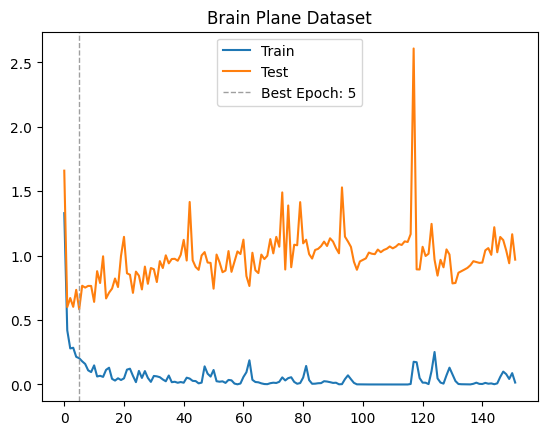

In [ ]:
bp_model.eval()
pred_list = []
label_list = []
with torch.no_grad():
  for inputs, labels in val_dataloader:
    inputs = inputs.to(device)
    outputs = bp_model(inputs)
    _, preds = torch.max(outputs, 1)
    pred_list = np.concatenate((pred_list, preds.detach().cpu().numpy()))
    label_list = np.concatenate((label_list, labels))

checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/bp_ckpt.pt'
_, _, _, full_train_losses, full_val_losses = load_model(checkpoint_save_path, device)
title = "Brain Plane Dataset"
plot_training_curve(full_train_losses, full_val_losses, best_epoch, title)

Accuracy: 0.8093883357041252
Precision: [0.84146341 0.70501475 0.8449848 ]
Recall: [0.81176471 0.79139073 0.820059  ]
F1: [0.82634731 0.74570983 0.83233533]
Support: [765 302 339]


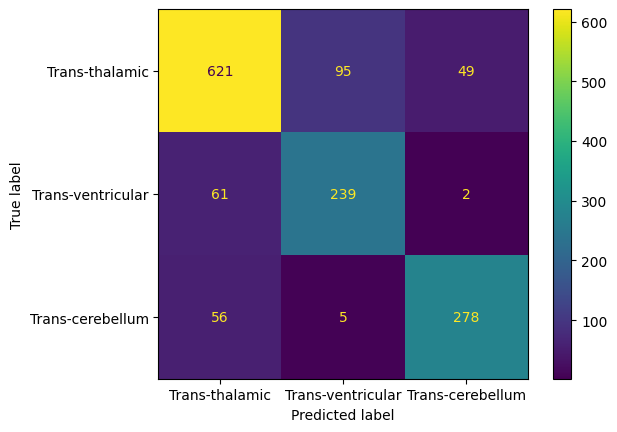

In [ ]:
class_names = ['Trans-thalamic', 'Trans-ventricular', 'Trans-cerebellum']
evaluate_model(label_list, pred_list, class_names)

# Split dataset 80/20

## Split fetal plane dataset

In [ ]:
# Load csv
fetal_plane_dataset_csv = pd.read_csv("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data.csv", delimiter=";")

# Get number of train and val
train_data = fetal_plane_dataset_csv.loc[fetal_plane_dataset_csv['Train ']==1]
val_data = fetal_plane_dataset_csv.loc[fetal_plane_dataset_csv['Train ']==0]
train_patient_num = train_data["Patient_num"].nunique()
val_patient_num = val_data["Patient_num"].nunique()
print(f"Number of patients in train {train_patient_num}, val {val_patient_num}")


# Get values for splitting
val_split = round((train_patient_num + val_patient_num) * 0.2)
train_split = round((train_patient_num + val_patient_num) * 0.8)
print(f"For 80/20 split, number of patients in train {train_split}, val {val_split}")
num_convert = train_split - train_patient_num
print(f"Number of validation images to convert {num_convert}")

# Convert validation to train
val_patient = val_data["Patient_num"].unique()
random.shuffle(val_patient)
for patient in val_patient[:num_convert]:
  fetal_plane_dataset_csv.loc[fetal_plane_dataset_csv["Patient_num"] == patient, "Train "] = 1

# Check all worked correctly
new_train_data = fetal_plane_dataset_csv.loc[fetal_plane_dataset_csv['Train ']==1]
new_val_data = fetal_plane_dataset_csv.loc[fetal_plane_dataset_csv['Train ']==0]

new_train_patient_num = new_train_data["Patient_num"].nunique()
new_val_patient_num = new_val_data["Patient_num"].nunique()

print(f"New number of patients in train {new_train_patient_num}, val {new_val_patient_num}")

# Save new csv
# fetal_plane_dataset_csv.to_csv("/content/drive/MyDrive/fetalplane_dataset/FETAL_PLANES_ZENODO/FETAL_PLANES_DB_data_8020.csv", index=False,sep=";")

print("Train", new_train_data["Plane"].value_counts())
print("Val", new_val_data["Plane"].value_counts())

Number of patients in train 896, val 896
For 80/20 split, number of patients in train 1434, val 358
Number of validation images to convert 538
New number of patients in train 1434, val 358
Train Other              3580
Fetal brain        2502
Fetal thorax       1452
Maternal cervix    1367
Fetal femur         832
Fetal abdomen       580
Name: Plane, dtype: int64
Val Other              633
Fetal brain        590
Fetal thorax       266
Maternal cervix    259
Fetal femur        208
Fetal abdomen      131
Name: Plane, dtype: int64


## Split African dataset

In [ ]:
african_dataset_csv = pd.read_csv("/content/drive/MyDrive/african_dataset/African_planes_database.csv", delimiter=",")

# Using filename to give each patient an ID to split on
filename = african_dataset_csv["Filename"]
patient_id = [f.split("_plane")[0] for f in filename]
african_dataset_csv["Patient_id"] = patient_id

# Get number of traina and val
train_data = african_dataset_csv.loc[african_dataset_csv['Train']==1]
val_data = african_dataset_csv.loc[african_dataset_csv['Train']==0]
train_patient_num = train_data["Patient_id"].nunique()
val_patient_num = val_data["Patient_id"].nunique()
print(f"Number of patients in train {train_patient_num}, val {val_patient_num}")

# Get values for splitting
val_split = round((train_patient_num + val_patient_num) * 0.2)
train_split = round((train_patient_num + val_patient_num) * 0.8)
print(f"For 80/20 split, number of patients in train {train_split}, val {val_split}")
num_convert = train_split - train_patient_num
print(f"Number of validation images to convert {num_convert}")

# Convert val to train
val_patient = list(val_data["Patient_id"].unique())
random.shuffle(val_patient)
for patient in val_patient[:num_convert]:
  african_dataset_csv.loc[african_dataset_csv["Patient_id"] == patient, "Train"] = 1

# Check all working correctly
new_train_data = african_dataset_csv.loc[african_dataset_csv['Train']==1]
new_val_data = african_dataset_csv.loc[african_dataset_csv['Train']==0]
new_train_patient_num = new_train_data["Patient_id"].nunique()
new_val_patient_num = new_val_data["Patient_id"].nunique()
print(f"New number of patients in train {new_train_patient_num}, val {new_val_patient_num}")

# Drop ID column to keep original columns and save
african_dataset_csv.drop(["Patient_id"], axis=1)
# african_dataset_csv.to_csv("/content/drive/MyDrive/african_dataset/African_planes_database_8020.csv", index=False,sep=",")

Number of patients in train 61, val 66
For 80/20 split, number of patients in train 102, val 25
Number of validation images to convert 41
New number of patients in train 102, val 25


In [ ]:
new_train_data["Plane"].value_counts()

Fetal femur      102
Fetal brain      101
Fetal abdomen    101
Fetal thorax      58
Name: Plane, dtype: int64

In [ ]:
new_val_data["Plane"].value_counts()

Fetal abdomen    24
Fetal brain      24
Fetal femur      23
Fetal thorax     17
Name: Plane, dtype: int64